In [1]:
import snntorch as snn
from snntorch import spikegen
from snntorch import surrogate
import snntorch.functional as SF
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import nn_optimizer
from torch import optim
import optimizee
from torch.autograd import Variable

from typing import Any
from functools import reduce
from operator import mul

In [2]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            

def train_optimizer_snn(device):
    num_epoch = 1
    updates_per_epoch = 5
    optimizer_steps = 200
    truncated_bptt_step = 10
    batch_size = 32

    meta_model = optimizee.mnist.MnistSpikingConvModel()
    meta_model.to(device)
    train_loader, test_loader = meta_model.dataset_loader(batch_size=batch_size)
    train_loader = iter(cycle(train_loader))


    meta_optimizer = nn_optimizer.zoopt.ZOOptimizer(optimizee.MetaModel(meta_model))
    meta_optimizer.to(device)

    optimizer = optim.Adam(meta_optimizer.parameters(), lr=1e-3)

    test_lost_hist = []
    counter = 0

    optimizer_loss_hist = []

    for epoch in range(num_epoch):
        meta_optimizer.train()
        decrease_in_loss = 0.0
        final_loss = 0.0
        for i in range(updates_per_epoch):
            
            # sample new model
            model = optimizee.mnist.MnistSpikingConvModel().to(device)
            data, target = next(train_loader)
            data, target = Variable(data.double()).to(device), Variable(target).to(device)

            # initials
            spk_rec = model(data.view(batch_size, -1))
            initial_loss = SF.ce_rate_loss(spk_rec, target)

            for k in range(optimizer_steps // truncated_bptt_step):
                meta_optimizer.reset_state(keep_states=k>0, model=model, use_cuda=True)

                loss_sum = 0
                prev_loss = torch.zeros(1).to(device)

                for j in range(truncated_bptt_step):
                    # Perfom a meta update using gradients from model
                    # and return the current meta model saved in the nn_optimizer
                    meta_model, *_ = meta_optimizer.meta_update(model, data.view(batch_size, -1), target)
                    
                    # Compute a loss for a step the meta nn_optimizer
                    # Use first-order method to train the zeroth-order optimizer
                    # (assume the gradient is available in training time)
                    f_x = meta_model(data.view(batch_size, -1))
                    loss = meta_model.loss(f_x, target)

                    loss_sum += (k * truncated_bptt_step + j) * (loss - Variable(prev_loss))
                    prev_loss = loss.data

                    if hasattr(meta_optimizer, "reg_loss"):
                        loss_sum += meta_optimizer.reg_loss
                    if hasattr(meta_optimizer, "grad_reg_loss"):
                        loss_sum += meta_optimizer.grad_reg_loss

                # Update the parameters of the meta nn_optimizer
                meta_optimizer.zero_grad()
                loss_sum.backward()
                optimizer_loss_hist.append(loss_sum.item())
                for name, param in meta_optimizer.named_parameters():
                    if param.requires_grad:
                        param.grad.data.clamp_(-1, 1)
                optimizer.step()
            
            print_batch_accuracy(model, data, target, batch_size, train=True)
            print(f"Last optimizer loss: {optimizer_loss_hist[-1]}")

    return meta_optimizer, optimizer_loss_hist

In [3]:

def train2(device):
    num_epoch = 2
    updates_per_epoch = 5
    optimizer_steps = 200
    truncated_bptt_step = 10
    batch_size = 32

    meta_model = optimizee.mnist.MnistSpikingConvModel()
    meta_model.to(device)
    train_loader, test_loader = meta_model.dataset_loader(batch_size=batch_size)
    train_loader = iter(cycle(train_loader))


    meta_optimizer = nn_optimizer.zoopt.ZOOptimizer(optimizee.MetaModel(meta_model))
    meta_optimizer.to(device)

    optimizer = optim.Adam(meta_optimizer.parameters(), lr=1e-3)

    test_lost_hist = []
    counter = 0

    optimizer_loss_hist = []

    for epoch in range(num_epoch):
        meta_optimizer.train()
        decrease_in_loss = 0
        final_loss = 0
        for i in range(updates_per_epoch):
            
            # sample new model
            model = optimizee.mnist.MnistSpikingConvModel().to(device)
            data, target = next(train_loader)
            data, target = Variable(data.double()).to(device), Variable(target).to(device)

            # initials
            spk_rec = model(data.view(batch_size, -1))
            initial_loss = model.loss(spk_rec, target) # SF.ce_rate_loss()

            for k in range(optimizer_steps // truncated_bptt_step):
                meta_optimizer.reset_state(keep_states=k>0, model=model, use_cuda=True)

                loss_sum = 0
                prev_loss = torch.zeros(1).to(device)

                for j in range(truncated_bptt_step):
                    # Perfom a meta update using gradients from model
                    # and return the current meta model saved in the nn_optimizer


                    data, target = next(train_loader)
                    data, target = Variable(data.double()).to(device), Variable(target).to(device)
                    
                    # compute gradient (FO)
                    spk_rec = model(data.view(batch_size, -1))
                    loss = model.loss(spk_rec, target)
                    model.zero_grad()
                    loss.backward()

                    meta_model = meta_optimizer.meta_update2(model)

                    # Compute a loss for a step the meta nn_optimizer
                    # Use first-order method to train the zeroth-order optimizer
                    # (assume the gradient is available in training time)
                    spk_rec = meta_model(data.view(batch_size, -1))
                    loss = meta_model.loss(spk_rec, target)

                    # loss_sum += (k * truncated_bptt_step + j) * (loss - Variable(prev_loss))
                    loss_sum += loss - Variable(prev_loss)
                    prev_loss = loss.data

                    if hasattr(meta_optimizer, "reg_loss"):
                        loss_sum += meta_optimizer.reg_loss
                    if hasattr(meta_optimizer, "grad_reg_loss"):
                        loss_sum += meta_optimizer.grad_reg_loss

                # Update the parameters of the meta nn_optimizer
                meta_optimizer.zero_grad()
                loss_sum.backward()
                for name, param in meta_optimizer.named_parameters():
                    if param.requires_grad:
                        param.grad.data.clamp_(-1, 1)
                optimizer.step()
            
            decrease_in_loss += loss.item() / initial_loss.item()
            final_loss += loss.item()

        print("Epoch: {}, final loss {}, average final/initial loss ratio: {}".format(epoch, final_loss / updates_per_epoch,
                                                                       decrease_in_loss / updates_per_epoch))

    return meta_optimizer, optimizer_loss_hist

In [4]:
dtype = torch.double
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

meta_optimizer, optimizer_loss_hist = train2(device)

# fig = plt.figure(facecolor="w", figsize=(10, 5))
# plt.plot(optimizer_loss_hist)
# plt.title("Loss Curves")
# plt.legend(["Train Loss", "Test Loss"])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()


torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([795010, 1, 10])
torch.Size([795010, 1, 1])
torch.Size([795010])
torch.Size([

KeyboardInterrupt: 

In [ ]:
def print_batch_accuracy(model, data, targets, batch_size, train=False):
    output = model(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(model, batch_size, data, targets, test_data, test_targets, epoch, iter_counter, counter, loss_hist, test_loss_hist):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(model, data, targets, batch_size, train=True)
    print_batch_accuracy(model, test_data, test_targets, batch_size, train=False)
    print("\n")

In [ ]:
def test_meta_optimizer(meta_optimizer, device):
    
    num_epoch = 1
    batch_size = 128

    meta_model = optimizee.mnist.MnistSpikingConvModel()
    meta_model.to(device)
    train_loader, test_loader = meta_model.dataset_loader(batch_size=batch_size, test_batch_size=batch_size)

    meta_optimizer.eval()
    model = optimizee.mnist.MnistSpikingConvModel().to(device)
    meta_optimizer.reset_state(keep_states=False, model=model)
    loss_hist = []
    test_loss_hist = []
    counter = 0
    for epoch in range(num_epoch):
        iter_counter = 0
        train_batch = iter(train_loader)
        for train_data, train_target in train_batch:
            train_data, train_target = Variable(train_data.double()).to(device), Variable(train_target).to(device)
            
            model.train()
            spk_rec = model(train_data.view(batch_size, -1))
            loss = model.loss(spk_rec, train_target)
            model.zero_grad()
            loss.backward()

            with torch.no_grad():
                _ = meta_optimizer.meta_update2(model)
            
            loss_hist.append(loss.item())

            with torch.no_grad():
                model.eval()
                test_data, test_targets = next(iter(test_loader))
                test_data, test_targets = Variable(test_data.double()).to(device), Variable(test_targets).to(device)

                # Test set forward pass
                test_spk = model(test_data.view(batch_size, -1))
                test_loss = model.loss(test_spk, test_targets)
                test_loss_hist.append(test_loss.item())

                # Print train/test loss/accuracy
                if counter % 50 == 0:
                    train_printer(model, batch_size, train_data, train_target, test_data, test_targets, epoch, iter_counter, counter, loss_hist, test_loss_hist)
                counter += 1
                iter_counter +=1
    
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(loss_hist)
    plt.plot(test_loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    return model

Epoch 0, Iteration 0
Train Set Loss: 2.31
Test Set Loss: 2.29
Train set accuracy for a single minibatch: 19.53%
Test set accuracy for a single minibatch: 11.72%


Epoch 0, Iteration 50
Train Set Loss: 1.70
Test Set Loss: 1.62
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 100
Train Set Loss: 1.60
Test Set Loss: 1.58
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 95.31%


Epoch 0, Iteration 150
Train Set Loss: 1.56
Test Set Loss: 1.58
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 200
Train Set Loss: 1.58
Test Set Loss: 1.57
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 250
Train Set Loss: 1.60
Test Set Loss: 1.58
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 89.84%


Epoch 0, Iter

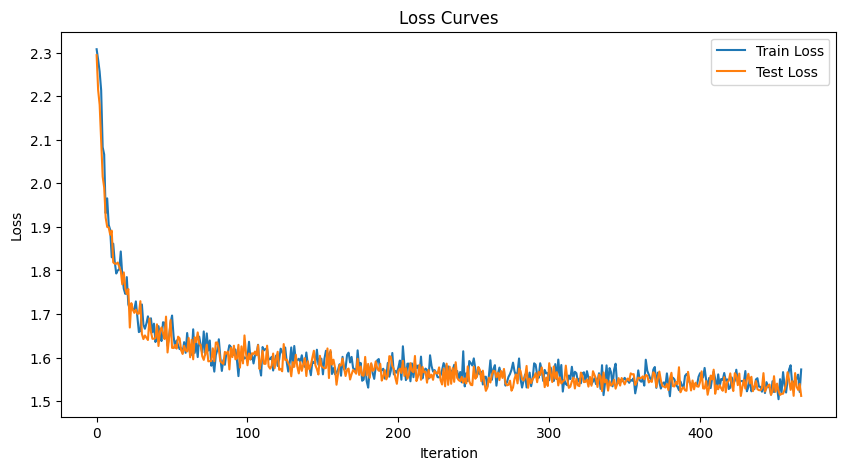

In [ ]:
model = test_meta_optimizer(meta_optimizer, device)